# 8. RNNs

## 8.1. Sequence Models

### 8.1.2. Training

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

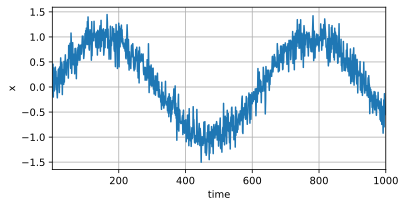

In [3]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [4]:
tau = 4
features = torch.zeros((T-tau, tau))

for i in range(tau):
    features[:, i] = x[i: T - tau + i]

labels = x[tau:].reshape((-1,1))

In [6]:
batch_size, n_train = 16, 600

train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()

        print(f'epoch {epoch + 1},'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [9]:
net = get_net()
train(net, train_iter ,loss, 5, 0.01)

epoch 1,loss: 0.061410
epoch 2,loss: 0.058862
epoch 3,loss: 0.055483
epoch 4,loss: 0.053698
epoch 5,loss: 0.057592


### 8.1.3. Predictions

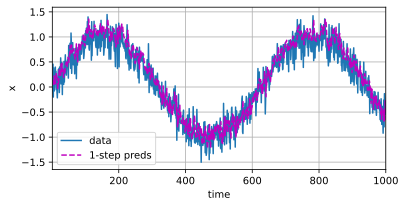

In [11]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1,1000], figsize=(6,3))

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train+tau]

for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1,-1)))

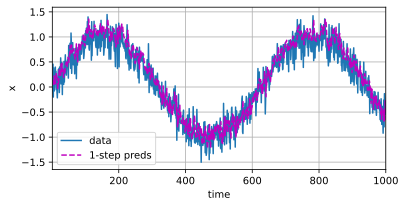

In [14]:
d2l.plot([time, time[tau:], time[n_train+tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1,1000], figsize=(6,3))

In [15]:
max_steps = 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))

for i in range(tau):
    features[:, i] = x[i:i+T-tau-max_steps+1]

for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1)

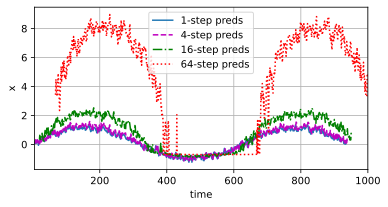

In [16]:
steps = (1,4,16,64)
d2l.plot([time[tau+i-1: T-max_steps+i] for i in steps],
         [features[:, (tau+i-1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5,1000],
         figsize=(6,3))

## 8.2. Text Processing

In [17]:
import collections
import re

### 8.2.1. Reading the Dataset

In [19]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### 8.2.2. Tokenization

In [20]:
def tokenize(lines, token='word'):
    """
    Split text lines into word or character tokens.
    """

    if token=='word':
        return [line.split() for line in lines]
    
    elif token == 'char':
        return [list(line) for line in lines]

    else:
        print('ERROR: unknown token type: ' + token)


tokens = tokenize(lines)

for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### 8.2.3. Vocab

In [27]:
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse = True)

        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx 
                             for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    
    return collections.Counter(tokens)

In [28]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [29]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


### 8.2.4. Putting All Things Together

In [30]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)

    corpus = [vocab[token] for line in tokens for token in line]

    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 8.3. Language Models and the Dataset

### 8.3.3. Natural Language Statistics 

In [31]:
import random

In [32]:
tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

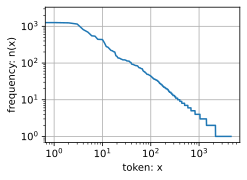

In [33]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [34]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [35]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

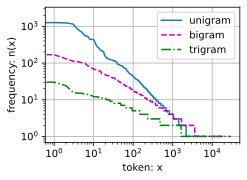

In [37]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log', legend=['unigram', 'bigram', 'trigram'])

### 8.3.4. Reading Long Sequence Data

In [38]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    corpus = corpus[random.randint(0, num_steps - 1):]
    num_subseqs = (len(corpus)-1) // num_steps

    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))

    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos+num_steps]
    
    num_batches = num_subseqs // batch_size

    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [40]:
my_seq = list(range(35))

for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]]) 
Y:  tensor([[25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34]])
X:  tensor([[19, 20, 21, 22, 23],
        [ 9, 10, 11, 12, 13]]) 
Y:  tensor([[20, 21, 22, 23, 24],
        [10, 11, 12, 13, 14]])
X:  tensor([[14, 15, 16, 17, 18],
        [ 4,  5,  6,  7,  8]]) 
Y:  tensor([[15, 16, 17, 18, 19],
        [ 5,  6,  7,  8,  9]])


In [41]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps

    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i+num_steps]
        Y = Ys[:, i: i+num_steps]
        yield X, Y

In [42]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y:  tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y:  tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [43]:
class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [45]:
def load_data_time_machine(batch_size, num_steps, use_random_iter = False, max_tokens = 10000):
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens
    )
    return data_iter, data_iter.vocab

## 8.4. Recurrent Neural Networks

In [46]:
X, W_xh = torch.normal(0,1, (3,1)), torch.normal(0,1,(1,4))
H, W_hh = torch.normal(0,1, (3,4)), torch.normal(0,1,(4,4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 1.0983, -0.1576,  1.3408,  1.1250],
        [ 4.5475, -4.0655,  4.6126, -1.3154],
        [-1.9239,  1.1708, -2.6005, -0.9069]])

In [49]:
torch.matmul(torch.cat((X,H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.0983, -0.1576,  1.3408,  1.1250],
        [ 4.5475, -4.0655,  4.6126, -1.3154],
        [-1.9239,  1.1708, -2.6005, -0.9069]])